# Hard disk collisions

Here is a possible implementation of an event-driven algorithm for hard disks.

In [2]:
import numpy as np
import numpy.random as rnd

class Disks(object):
    """A class describing many disks in a box"""
    
    def __init__(self, n_disks, radius=0.01):
        """Create randomly several disks"""
        
        self.n_disks = n_disks
        self.radius = radius
        self.positions = rnd.random([n_disks, 2])*(1-2*radius)+radius
        self.velocities = rnd.random([n_disks, 2])*2-1.
        self.events = np.zeros([n_disks, 4+n_disks])*np.nan
        self.walls = np.array([1.,1.,0.,0.])
        for i in range(n_disks): self.update_events(i)
        
    def update_events(self, p):
        """Update the events for the p^th disk"""
        
        pos = self.positions[p,:]
        vel = self.velocities[p,:]
        walls = self.walls
        r = self.radius
        
        # no self-collision!
        self.events[p,p] = np.nan
        
        # collisions with a wall
        for i in range(4):
            s = 1 if i < 2 else -1
            if s * vel[i%2] > 0:
                self.events[p,i] = (walls[i] - pos[i%2] - s*r) / vel[i%2]
            else:
                self.events[p,i] = np.nan
        
        # collisions with other disks
        for i in range(self.n_disks):
            if i != p:
                t = self._time_to_collision(p, i)
                self.events[p,i+4] = t
                self.events[i,p+4] = t
                
    def step(self, dt):
        """Make a time step dt"""
        
        # find event with smallest time
        ind = np.unravel_index(np.nanargmin(self.events), self.events.shape)
        t_coll = self.events[ind]
        
        if dt < t_coll:
            self.positions += self.velocities * dt
            self.events -= dt
        else:
            self.positions += self.velocities * t_coll
            self.events -= t_coll
            self._new_velocities(ind)
            self.step(dt - t_coll)
            
            
    def _time_to_collision(self, p1, p2):
        """Helper method to find disk-disk collision time"""
        
        sigma = 2 * self.radius
        delta_v = self.velocities[p2,:] - self.velocities[p1,:]
        delta_r = self.positions[p2,:] - self.positions[p1,:]
        dvdr = np.dot(delta_v, delta_r)
        if dvdr > 0:
            return np.nan
        dvdv = np.dot(delta_v, delta_v)
        d = dvdr**2 -  dvdv * (np.dot(delta_r, delta_r) - sigma**2)
        if d < 0:
            return np.nan
        return -(dvdr + np.sqrt(d)) / dvdv
    
    def _new_velocities(self, ind):
        
        p1 = ind[0]
        
        # Event was a collision with wall
        if ind[1] < 4:    
            self.velocities[p1,ind[1]%2] = -self.velocities[p1,ind[1]%2]
            self.update_events(p1)

        # Event was collision with another disk
        else:
            
            p2 = ind[1]-4
            sigma = 2 * self.radius
            delta_v = self.velocities[p2,:] - self.velocities[p1,:]
            delta_r = self.positions[p2,:] - self.positions[p1,:]
            dvdr = np.dot(delta_v, delta_r)
            imp = 2*1*1*dvdr/(sigma*(1+1))
            imp_v = imp*delta_r/sigma
        
            self.velocities[p1,:] += imp_v
            self.velocities[p2,:] -= imp_v
            self.update_events(p1)
            self.update_events(p2)

The animation code is very similar to the code that we wrote for a single disk.

<IPython.core.display.Javascript object>


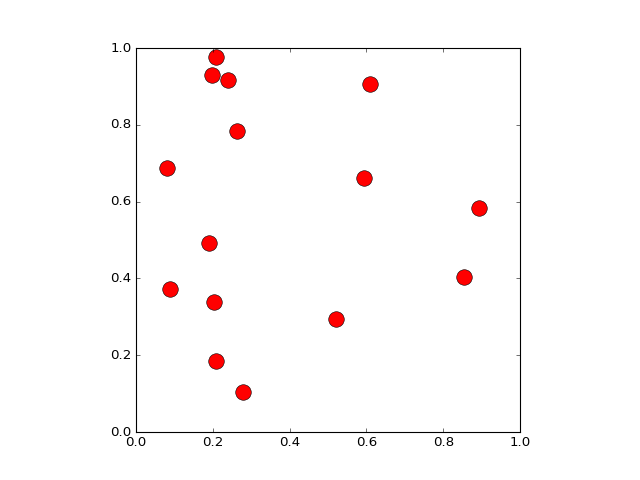

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

disks = Disks(15, 0.02)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
line, = ax.plot([], [], 'ro', ms=14)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
    
def animate(i):
    disks.step(0.01)
    line.set_data(disks.positions[:,0], disks.positions[:,1])
    return line,
    
anim = animation.FuncAnimation(fig, animate, interval=10, blit=False)

## Histogram of velocities

Here, we want to check whether the prediction of statistical mechanics
are verified by the hard disks. This is actually not so trivial and it would be nice
to see that the purely newtonian motion of the disks yields the expected results.
One quantity that we can measure is the distribution of the velocities. Maxwell-Boltzmann
predicts that the velocity vectors are distributed according to

\begin{equation}
  \rho(\vec{v}) = \Big( \frac{m}{2 \pi k_B T} \Big)^{d/2} e^{-\frac{m v^2}{2 k_B T}}
\end{equation}

We then deduce, for the norm of the velocity in two dimensions

\begin{equation}
  \rho(v) = \frac{m}{k_B T} v e^{-\frac{m v^2}{2 k_B T}}
\end{equation}

Let's check that after some time, the distribution of the velocities
obeys this law and that the temperature $T$ in the formula is
compatible with the temperature you would find from the total
energy (that is conserved and determined by the original choice
of all velocities):

\begin{equation}
  E = \frac{d}{2} k_B T = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} m v_i^2
\end{equation}

In [3]:
class Histogram(object):
    
    def __init__(self, x_min, x_max, n_bins):
        self.x_min, self.x_max = x_min, x_max
        self.x_values, self.delta = np.linspace(x_min, x_max, n_bins, retstep=True)
        self.y_values = np.zeros(len(self.x_values))
        self.n_values = 0
        
    def __lshift__(self, value):
        ind = np.int((value-self.x_min)/self.delta)
        if (ind >= 0) and (ind < len(self.x_values)):
            self.y_values[np.int((value-self.x_min)/self.delta)] += 1
            self.n_values += 1

And now we construct an animation with the probability distribution of velocities
and the theoretical curve.

Total energy =  0.291693229958


<IPython.core.display.Javascript object>


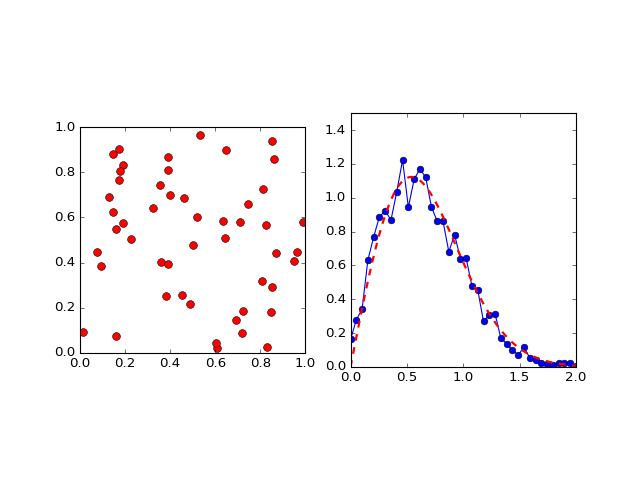

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

disks = Disks(50)

energy = 0.0
for i in range(disks.n_disks):
    energy += 0.5*np.dot(disks.velocities[i,:], disks.velocities[i,:])
energy /= disks.n_disks
print 'Total energy = ', energy

histo = Histogram(0,2,40)

fig = plt.figure()
ax = fig.add_subplot(121, aspect='equal')
line, = ax.plot([], [], 'ro', ms=7)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax = fig.add_subplot(122, aspect=1.5)
hist, = ax.plot([], [], '-o')
vr = np.linspace(0,2,100)
ax.plot(vr, (1/energy)*vr*np.exp(-vr*vr/energy/2), 'r--', lw=2)
ax.set_xlim(0,2)
ax.set_ylim(0,1.5)
    
def animate(i):
    disks.step(0.01)
    line.set_data(disks.positions[:,0], disks.positions[:,1])
    for j in range(disks.n_disks):
        v = disks.velocities[j,:]
        histo << np.sqrt(np.dot(v,v))
    hist.set_data(histo.x_values, histo.y_values/histo.n_values/histo.delta)
    return (line, hist)
    
anim = animation.FuncAnimation(fig, animate, interval=5, blit=False,frames=3000)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=32, metadata=dict(artist='Me'), bitrate=1800)

anim.save('balls.mp4',writer=writer)

In [12]:
animation.FuncAnimation.save?